In [428]:
import csv
import requests
import numpy as np
import pandas as pd
from io import StringIO
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from datetime import datetime
import matplotlib.patches as patches
import matplotlib.lines as mlines
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,
                                  AnnotationBbox)

plt.close('all')

In [429]:
CSV_URL = 'https://covidtracking.com/api/v1/states/daily.csv'

with requests.Session() as s:
    download = s.get(CSV_URL)
    download
    decoded_content = download.content.decode('utf-8')
    cr = pd.read_csv(StringIO(decoded_content))
    df = pd.DataFrame(cr)   

In [430]:
date = pd.to_datetime(df['date'].astype(str), format='%Y%m%d')
df = pd.DataFrame({'date':date, 'state':df['state'], 'positiveIncrease':df['positiveIncrease']})
date.head()

0   2020-07-04
1   2020-07-04
2   2020-07-04
3   2020-07-04
4   2020-07-04
Name: date, dtype: datetime64[ns]

In [431]:
stateNames = ['WA', 'ID', 'MT', 'ND', 'MN','WI','MI','NY','VT', 'NH','ME',
             'OR','WY', 'SD', 'IA', 'IL', 'IN', 'OH', 'PA', 'MA', 'RI', 'CT', 'NJ',
             'DE', 'MD', 'DC', 'CA', 'NV', 'UT', 'CO', 'NE', 'MO', 'KS', 'OK', 'NM', 
              'AZ', 'TX', 'LA', 'AR', 'TN', 'MS', 'AL', 'KY', 'WV', 'VA', 'NC',
             'SC', 'GA', 'FL', 'AK', 'HI']
dfstates = []
len(stateNames)

51

In [432]:
# I'm sure there's a cleaner way to do this...

for name in stateNames:
    sel = df[(df['state']==name)]
    sel.index=sel['date']
    dfstates.insert(len(dfstates), sel)
s = 'positiveIncrease'
dfgroup = pd.DataFrame()

for d in dfstates:
    dfgroup[d['state'][0]] = d[s]

In [433]:
#Define color pallete

redBar = '#ECCFC2'
twoWeeksRisingColor = '#F0EBD8'
threeWeeksIncreaseColor = '#F2DFAE'
sevenDayDecreaseColor = '#D8F0DF'
borderColor = "#E1DDBF"
fourWeeksIncreaseColor = '#F5DFDC'
increaseColor = '#E6A88A'
decreaseColor = '#7CA86D'
titleColor = '#706343'
labelColor = '#706D65'

In [434]:
def formatBorder(ax):
    for spineName in ax.spines:
        ax.spines[spineName].set_color(borderColor)
        ax.spines[spineName].set_linewidth(2)

In [435]:
def sumRange(L,a,b):                                                                                                                                                                                                
    sum = 0                                                                                                                                                                                                         
    for i in range(a,b+1,1):                                                                                                                                                                                        
        sum += L[i]                                                                                                                                                                                                  
    return sum      

In [436]:
def consecutiveWeeksIncreased(state):
    weeks = 0
    prev = 999999
    for week in range(10):
        thisWeekSum = sumRange(state, weeks * 7, weeks * 7 + 8)
        if thisWeekSum <= prev:
            prev = thisWeekSum
            weeks += 1
        else:
            return weeks
    return weeks

In [437]:
def getLastIncreaseChange(state):
    return int(dfgroup[state][1]) - int(dfgroup[state][0])
def getIncreaseSign(increase):
    if(increase >= 0):
        return '+'
    else:
        return ''
def getIncreaseColor(increase):
    if(increase >= 0):
        return increaseColor
    else:
        return decreaseColor

In [438]:
# In progress
def createAnnotationBox(ax, text):
    offsetbox = TextArea(text, minimumdescent=False)
    ab = AnnotationBbox(offsetbox, xy=(0.025, .6),
                    xybox=(0.025, .6),
                    xycoords='axes fraction',
                    boxcoords="axes fraction",
                    bboxprops = 
                            dict(facecolor=borderColor, alpha=.1,boxstyle='round',color=borderColor))
    ax.add_artist(ab)

In [439]:
def do_plot(ax, name):
    color = 'C'+str(dfgroup.columns.get_loc(name))
    ax.plot(dfgroup[name], color=(color), linewidth=1)
    ax.set_xlabel('')
    ax.grid(False)
    ax.set_xticklabels('')
    ax.set_yticklabels('')
    ax.set_title(name,horizontalalignment='left', color=(color), fontweight="bold", fontsize=12, x=0.025, y=.75)
    formatBorder(ax)
    weeksClimbing = consecutiveWeeksIncreased(dfgroup[name])
    if(weeksClimbing >= 4):
        ax.set_facecolor(fourWeeksIncreaseColor)
    else :
        if(weeksClimbing >=3):
            ax.set_facecolor(threeWeeksIncreaseColor)
        else:
            if(weeksClimbing >= 2):
                ax.set_facecolor(twoWeeksRisingColor)
    ax.axhline(y=100, color='r', linestyle='-', linewidth=.2)
    lastChange = getLastIncreaseChange(name)
    changeNote = '(' + getIncreaseSign(lastChange) + str(lastChange) + ')'
    #Latest increase
    ax.annotate(s= '+'+str(int(dfgroup[name][0])), xy=(.025, 0.7), xycoords='axes fraction', fontsize=9, color=labelColor)
    #Latest increase vs previous day
    ax.annotate(s= changeNote, xy=(.025, 0.6), xycoords='axes fraction', fontsize=9, color=getIncreaseColor(lastChange))
    #createAnnotationBox(ax, changeNote)

In [440]:
def add_state(figure, stateName, grid):
    state = figure.add_subplot(grid)
    do_plot(state, stateName)
    return state

In [441]:
#Last updated on string
now = datetime.now()
dt_string = now.strftime("%m/%d/%Y %H:%M:%S")
dt_string = "Last updated " + dt_string

In [442]:
#Subtitle - date range
lastDate = date[0]
lastDate = lastDate = lastDate.month_name() + ' ' + str(lastDate.day)
shape = date.shape
firstDate = date[shape[0]-1]
firstDate = firstDate.month_name() + ' ' + str(firstDate.day)
dateRangeString = 'From ' + firstDate + ' to ' + lastDate
dateRangeString

'From January 22 to July 4'

In [443]:
def add_column(fig, names, column, grid):
    row = 0
    for name in names:
        if(name == ""):
            row+=1
            continue
        else:
            add_state(fig, name, grid[row, column])
            row+=1

Text(0.96, 0.25, 'Data collected via covidtracking.com')

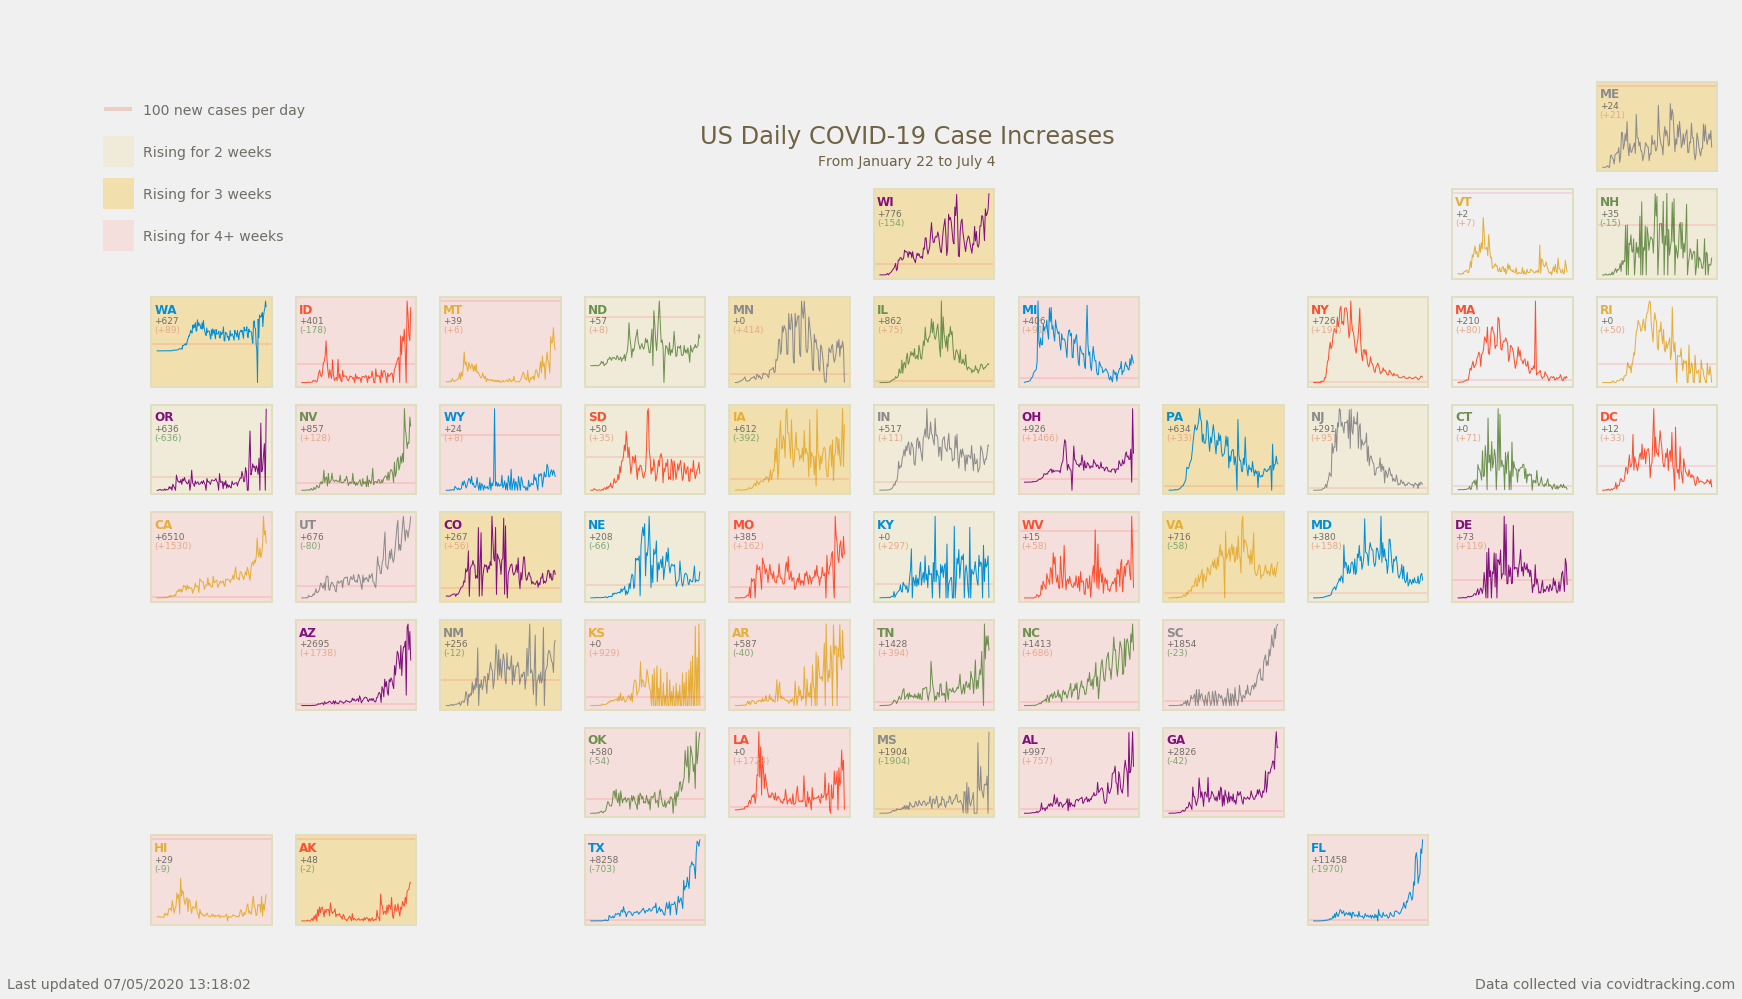

In [444]:
plt.style.use('fivethirtyeight')

g = gridspec.GridSpec(11, 11)

fig = plt.figure(figsize=(25,20))

#Title
fig.suptitle('US Daily COVID-19 Case Increases', y=0.85, fontsize=24, color=titleColor)
fig.text(.5, .822, s=dateRangeString, color = titleColor, horizontalAlignment = 'center')


#fig.text('From ')

#'Last updated on'
fig.text(x=0, y=.25, s=dt_string, color = labelColor)

x = .1
y =.75


#Create legend
redline = mlines.Line2D([], [], color=redBar, marker='', markersize=15, label='100 new cases per day')
twoWeeksIncrease = mlines.Line2D([],[], color = twoWeeksRisingColor, marker='s',markersize=30, label='Rising for 2 weeks')
threeWeeksIncrease = mlines.Line2D([],[], color = threeWeeksIncreaseColor, marker='s',markersize=30, label='Rising for 3 weeks')
fourWeeksIncrease = mlines.Line2D([],[], color = fourWeeksIncreaseColor, marker='s',markersize=30, label='Rising for 4+ weeks')

legend = fig.legend(handles=[redline, twoWeeksIncrease, threeWeeksIncrease, fourWeeksIncrease], loc='upper left',borderaxespad=7, framealpha=0, labelspacing=2)

for t in legend.get_texts():
    t.set_color(labelColor)
    

# Create state subplots
add_column(fig, ['', '', 'WA', 'OR', 'CA',  '', '', 'HI'], 0, g)
add_column(fig, ['', '', 'ID', 'NV', 'UT', 'AZ', '', 'AK'], 1, g)
add_column(fig, ['','', 'MT', 'WY', 'CO', 'NM'], 2, g)
add_column(fig, ['','','ND','SD', 'NE', 'KS', 'OK', 'TX'], 3, g)
add_column(fig, ['', '', 'MN', 'IA', 'MO', 'AR', 'LA'], 4, g)
add_column(fig, ['', 'WI', 'IL', 'IN', 'KY', 'TN', 'MS'], 5, g)
add_column(fig, ['', '','MI', 'OH', 'WV', 'NC', 'AL'], 6, g)
add_column(fig, ['', '', '', 'PA', 'VA', 'SC', 'GA'], 7, g)
add_column(fig, ['', '', 'NY', 'NJ', 'MD', '', '', 'FL'], 8, g)
add_column(fig, ['', 'VT', 'MA', 'CT', 'DE'], 9, g)
add_column(fig, ['ME', 'NH', 'RI', 'DC'], 10, g)

#Data source label
fig.text(x=.96, y=.25, s='Data collected via covidtracking.com', color = labelColor, horizontalAlignment='right')